In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import autocorrelation_plot

%matplotlib inline

## Math

$$Pr(y | \cdot) = \prod^n_i p_i^y(1 - p_i)^{1 - y_i}$$

$$\log(Pr(y | \cdot)) = \sum^n_i y_i( \beta_0 + \beta_1x_i + \beta_2x^2) - \sum^n_i (1 + \exp(\beta_0 + \beta_1x_i + \beta_2x^2))$$

In [2]:
data = pd.read_table('http://health.bsd.uchicago.edu/yji/Bayes2017/Homework/logit.txt', header=None, sep='\s+')
data.columns = ['x', 'y']

In [23]:
X = data['x'].values.reshape((-1, 1))
Y = data['y'].values.reshape((-1, 1))

X -= X.mean()
X /= X.std()

X2 = X ** 2  # precompute
# X1 = np.concatenate([np.ones_like(X), X], axis=1)
# X12 = np.concatenate([X, X2], axis=1)

num_samples = 80000
m = np.ones(num_samples)
h = 0.5

beta01 = np.ones((num_samples, 2))
beta2 = np.zeros((num_samples, 1))

std_beta = np.sqrt(10)
std_u = np.sqrt(1)
tau = np.sqrt(0.05)

num_obs = len(data)

In [24]:
def sample01(b01):
    curr = b01
    prop = curr + stats.norm(0, tau).rvs(2)
    # Ratio
    like_ratio = LLK(curr, prop, 1, 1, 'sample 1')
    prior_ratio = np.sum(np.log(stats.norm(0, std_beta).pdf(prop))) -\
                  np.sum(np.log(stats.norm(0, std_beta).pdf(curr)))
        
    acp = like_ratio + prior_ratio
    if acp > np.log(np.random.uniform()):
        return prop
    else:
        return curr


def sample012(b01, b2):
    curr = np.concatenate([b01, b2])
    prop = curr + stats.norm(0, tau).rvs(3)

    like_ratio = LLK(curr, prop, 2, 2, 'sample 2')

    prior_ratio = np.sum(np.log(stats.norm(0, std_beta).pdf(prop))) - \
                  np.sum(np.log(stats.norm(0, std_beta).pdf(curr)))

    acp = like_ratio + prior_ratio
    if acp > np.log(np.random.uniform()):
        return prop
    else:
        return curr


def LLK(currBeta, propBeta, modelCurr, modelProp, name):
    
    if modelCurr == 1:
        currBeta2 = 0
    else:
        currBeta2 = currBeta[2]

    if modelProp == 1:
        propBeta2 = 0
    else:
        propBeta2 = propBeta[2]

    like_ratio = np.sum(Y * (propBeta[0] + propBeta[1] * X + propBeta2 * X2 - currBeta[0] - currBeta[1] * X - currBeta2 * X2) +\
                        np.log(1 + np.exp(currBeta[0] + currBeta[1] * X + currBeta2 * X2)) -\
                        np.log(1 + np.exp(propBeta[0] + propBeta[1] * X + propBeta2 * X2)))

    return like_ratio

In [25]:
for sim in tqdm.trange(num_samples - 1):

    if m[sim] == 1:

        chg_ind = np.random.rand() < h

        if chg_ind:

            u = stats.norm(0, std_u).rvs(1)
            beta2_tmp = u
            beta012_prop = np.concatenate([beta01[sim], beta2_tmp])

            like_ratio = LLK(beta01[sim], beta012_prop, 1, 2, 'add var')
            prior_ratio = stats.norm.logpdf(beta2_tmp, 0, std_beta)
            proposal = stats.norm.logpdf(u, 0, std_u)
            acc = like_ratio + prior_ratio + proposal
            ind = acc > np.log(np.random.rand())

            if ind:
                m[sim + 1] = 2
                beta2[sim + 1] = beta2_tmp
                beta01[sim + 1] = beta01[sim]
            else:
                m[sim + 1] = m[sim]
                beta2[sim + 1] = 0.0
                beta01[sim + 1] = beta01[sim]

        else:
            sample = sample01(beta01[sim])
            beta01[sim + 1] = sample
            beta2[sim + 1] = 0.0  # beta2[sim]
            m[sim + 1] = m[sim]

    else:
        chg_ind = np.random.rand() < h

        if chg_ind:

            u = beta2[sim]
            beta2_tmp = beta2[sim]
            beta012_prop = np.concatenate([beta01[sim], beta2_tmp])

            like_ratio = LLK(beta012_prop, beta01[sim], 2, 1, 'drop var')
            prior_ratio = np.log(stats.norm.pdf(beta2_tmp, loc=0, scale=std_beta))
            proposal = np.log(stats.norm.pdf(u, 0, std_u))
            acc = -like_ratio + prior_ratio - proposal

            ind = acc > np.log(np.random.rand())

            if ind:
                m[sim + 1] = 1
                beta2[sim + 1] = 0.
                beta01[sim + 1] = beta01[sim]

            else:
                m[sim + 1] = m[sim]
                
                beta01[sim + 1] = beta01[sim]
                beta2[sim + 1] = beta2[sim]

        else:
#             print 'here'
            sample = sample012(beta01[sim], beta2[sim])
            beta01[sim + 1] = sample[:2]
            beta2[sim + 1] = sample[2]
            m[sim + 1] = m[sim]

100%|██████████| 79999/79999 [03:40<00:00, 337.76it/s]


In [46]:
burnedValues = np.hstack([beta01, beta2])[10000::8]
burnedM = m[10000::8]
model1s = burnedM == 1

The simulation indicated that model 1 was better then model 2

In [47]:
burnedM.mean()

1.1542857142857144

In [48]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

## Model 1

#### The values are from mean centered and scaled data

In [49]:
print 'Means'
print '   Beta 0  ', '     Beta 1  ', '   Beta 2'
print burnedValues[model1s].mean(axis=0)

Means
   Beta 0        Beta 1      Beta 2
[ 0.18894441  1.45014477  0.        ]


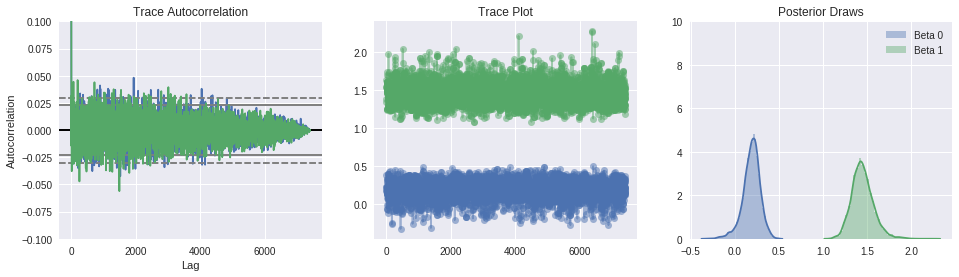

In [50]:
plt.figure(figsize=(16, 4))
_ = plt.subplot(131)
autocorrelation_plot(burnedValues[model1s, 0], ax=_)
autocorrelation_plot(burnedValues[model1s, 1], ax=_)
plt.ylim([-.1, .1])
plt.title('Trace Autocorrelation')
plt.subplot(132).plot(burnedValues[model1s, :2], '-o', alpha=0.5)
plt.title('Trace Plot')
ax = plt.subplot(133)
sns.distplot(burnedValues[model1s,0], ax=ax, bins=40, color=sns.color_palette()[0], label='Beta 0')
sns.distplot(burnedValues[model1s,1], ax=ax, bins=40, color=sns.color_palette()[1], label='Beta 1')
plt.ylim(0,10)
plt.legend()
plt.title('Posterior Draws');

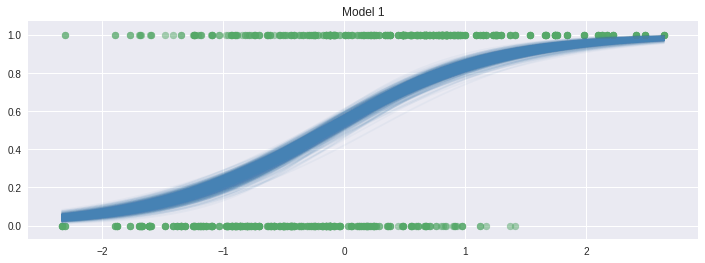

In [51]:
xp = np.linspace(X.min(), X.max())
plt.figure(figsize=(12, 4))
for b0, b1 in zip(burnedValues[model1s][::10, 0], burnedValues[model1s][::10, 1]):
    plt.plot(xp, invlogit(b0 +  b1* xp), color='steelblue', alpha=0.05)
plt.scatter(X, Y , color=sns.color_palette()[1], alpha= 0.5)
plt.title('Model 1');

## Model 2

In [52]:
print 'Means'
print '   Beta 0  ', '     Beta 1  ', '   Beta 2'
print burnedValues[~model1s].mean(axis=0)

Means
   Beta 0        Beta 1      Beta 2
[ 0.14684576  1.48483954  0.30755161]


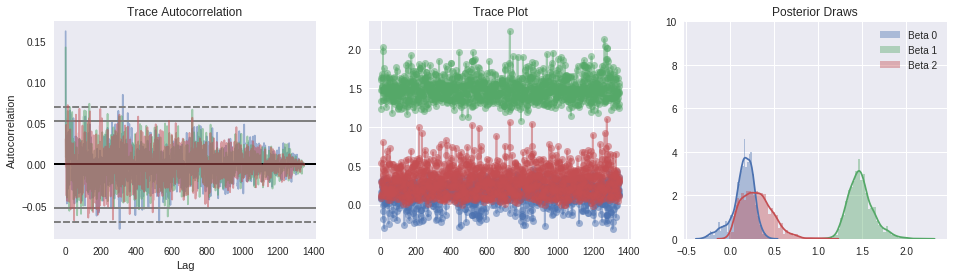

In [53]:
plt.figure(figsize=(16, 4))
_ = plt.subplot(131)
autocorrelation_plot(burnedValues[~model1s, 0], ax=_, alpha=0.5)
autocorrelation_plot(burnedValues[~model1s, 1], ax=_, alpha=0.5)
autocorrelation_plot(burnedValues[~model1s, 2], ax=_, alpha=0.5)
plt.title('Trace Autocorrelation')
plt.subplot(132).plot(burnedValues[~model1s], '-o', alpha=0.5)
plt.title('Trace Plot')
ax = plt.subplot(133)
sns.distplot(burnedValues[~model1s,0], ax=ax, bins=40, color=sns.color_palette()[0], label='Beta 0')
sns.distplot(burnedValues[~model1s,1], ax=ax, bins=40, color=sns.color_palette()[1], label='Beta 1')
sns.distplot(burnedValues[~model1s,2], ax=ax, bins=40, color=sns.color_palette()[2], label='Beta 2')
plt.ylim(0,10)
plt.legend()
plt.title('Posterior Draws');

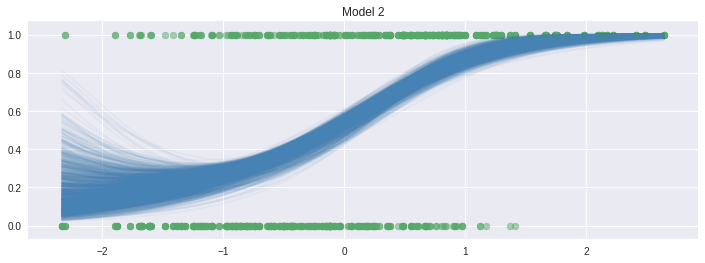

In [54]:
xp = np.linspace(X.min(), X.max())
plt.figure(figsize=(12, 4))
for b0, b1, b2 in zip(burnedValues[~model1s][:, 0], burnedValues[~model1s][:, 1], burnedValues[~model1s][:, 2]):
    plt.plot(xp, invlogit(b0 +  b1* xp + b2 * xp ** 2), color='steelblue', alpha=0.05)
plt.scatter(X, Y, color=sns.color_palette()[1], alpha= 0.5)
plt.title('Model 2');